In [ ]:
import torch.nn as nn 
import torch 
import glob 


In [2]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key_conv   = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value_conv = nn.Conv2d(in_dim, in_dim,    1)
        self.gamma      = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
       
        proj_q = self.query_conv(x).view(B, -1, H*W).permute(0,2,1)  # B×N×C'
        proj_k = self.key_conv(x).view(B, -1, H*W)                  # B×C'×N
        attn   = torch.softmax(torch.bmm(proj_q, proj_k), dim=-1)  # B×N×N
        proj_v = self.value_conv(x).view(B, -1, H*W)                # B×C×N
        out    = torch.bmm(proj_v, attn.permute(0,2,1))             # B×C×N
        out    = out.view(B, C, H, W)
        # Residual connection
        return self.gamma * out + x

In [ ]:
class Generator(nn.Module):
    def __init__(self,img_size, latent_dim, channels): 
        super(Generator, self).__init__() 
        self.init_size = int(img_size/4)  
        self.in_layer = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size**2) 
        ) 
        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            # nn.Upsample(scale_factor=2), 
            # nn.Conv2d(128, 128, 3, stride=1, padding=1), 
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True), 
            # SelfAttention(128),
            
            # nn.Upsample(scale_factor=2), 
            # nn.Conv2d(128, 64, 3, stride=1, padding=1), 
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Conv2d(64, channels, 3, stride=1, padding=1), 
            nn.Tanh(), 
        )

    def forward(self, x): 
        x = self.in_layer(x) 
        x = x.reshape(x.shape[0], 128, self.init_size, self.init_size) 
        x = self.model(x) 
        return x 

class Discriminator(nn.Module): 
    def __init__(self, channels, img_size): 
        super(Discriminator, self).__init__() 
        self.model = nn.Sequential(
            nn.Conv2d(channels, 16, 3, 2, 1), 
            nn.LeakyReLU(0.2), 
            nn.Dropout2d(0.25), 
            nn.Conv2d(16, 32, 3, 2, 1), 
            nn.LeakyReLU(0.2), 
            nn.Dropout2d(0.25), 
            nn.BatchNorm2d(32), 
            nn.Conv2d(32, 64, 3, 2, 1), 
            nn.LeakyReLU(0.2), 
            nn.Dropout2d(0.25), 
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.LeakyReLU(0.2), 
            nn.Dropout2d(0.25), 
            nn.BatchNorm2d(128), 
        ) 
        flat_img_size = int(img_size / 16)**2   ## acounts for downsampled image  
        self.out_layer = nn.Sequential( 
            nn.Linear(128 * flat_img_size, 1), 
            nn.Sigmoid() 
        ) 

    def forward(self, x): 
        x = self.model(x) 
        x = x.reshape(x.shape[0], -1) 
        x = self.out_layer(x) 
        return x 

In [4]:
import os
import numpy as np 
import torchvision.transforms as transforms
from torchvision.utils import save_image 
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision import models
import torchvision.transforms as T

# Normalization used by ImageNet pre-trained models
imagenet_norm = T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])

In [ ]:
# Hyperparameters 
data_dir = './dataset' 
result_dir = './results/18'
model_dir = './DCGAN_Model/18'
img_size = 64  
batch_size = 64 
lr = 1e-4 
epochs = 200  
save_every = 1  
latent_dim = 100  

lambda_fm   = 10.0

gen_steps = 2   # Number of updates per batch for the generator
disc_steps = 1  # Number of updates per batch for the discriminator 

gen_loss_history = []
dis_loss_history = []

loss_func = torch.nn.BCELoss()
generator = Generator(img_size=img_size, latent_dim=latent_dim, channels=3)  
discriminator = Discriminator(channels=3, img_size=img_size) 


device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator.to(device) 
discriminator.to(device)  
loss_func.to(device) 

def initialize_weights(m): 
    if isinstance(m, nn.Conv2d): 
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) 
    if isinstance(m, nn.BatchNorm2d): 
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02) 
        torch.nn.init.constant_(m.bias.data, 0.0) 

generator.apply(initialize_weights) 
discriminator.apply(initialize_weights)  

os.makedirs(data_dir, exist_ok=True) 
dataloader = torch.utils.data.DataLoader( 
    datasets.ImageFolder(data_dir, 
        transform=transforms.Compose([
            transforms.Resize(img_size), 
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0], std=[1]) 
            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

        ]) 
    ),  
    batch_size=batch_size, 
    shuffle=True     
) 

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)) 

Tensor = torch.cuda.FloatTensor 

# --- VGG16 feature extractor used for perceptual loss ---
vgg = models.vgg16(pretrained=True).features[:16].to(device)  # Features taken up to layer conv3_3
for p in vgg.parameters():
    p.requires_grad = False
vgg.eval()

# Weight coefficient for perceptual loss
lambda_perc = 0.01

for epoch in range(epochs): 
    for batch_idx, (data, target) in enumerate(dataloader): 
        img_true = Variable(Tensor(data.shape[0],1).fill_(1.0)) 
        img_false = Variable(Tensor(data.shape[0], 1).fill_(0.0)) 

        real_imgs = Variable(data.type(Tensor)) 

        # Generate fake images first for the discriminator
        z = Variable(Tensor(np.random.normal(0, 1, (data.size(0), latent_dim))))
        generated = generator(z)

        # Discriminator update
        for _ in range(disc_steps):
            fake_imgs = generated.detach()
            dis_optimizer.zero_grad()
            loss_real = loss_func(discriminator(real_imgs), img_true)
            loss_fake = loss_func(discriminator(fake_imgs), img_false)
            dis_loss = 0.5 * (loss_real + loss_fake)
            dis_loss.backward()
            dis_optimizer.step()

        # Generator Update
        # for _ in range(gen_steps):
        #     gen_optimizer.zero_grad()
        #     z = Variable(Tensor(np.random.normal(0, 1, (data.size(0), latent_dim))))
        #     generated = generator(z)
        #     gen_loss = loss_func(discriminator(generated), img_true)
        #     gen_loss.backward()
        #     gen_optimizer.step() 
        
        for _ in range(gen_steps):
            gen_optimizer.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (data.size(0), latent_dim))))
            generated = generator(z)

            # 1) Adversarial loss
            adv_loss = loss_func(discriminator(generated), img_true)

            # 2) Perceptual loss
            # Map generated images from [-1, 1] to [0, 1]
            gen_imgs01 = (generated + 1) / 2
            real_imgs01 = (real_imgs + 1) / 2

            # Apply ImageNet normalization
            gen_in = imagenet_norm(gen_imgs01)
            real_in = imagenet_norm(real_imgs01)

            # Extract features and compute L1 loss
            feat_gen = vgg(gen_in)
            feat_real = vgg(real_in)
            perc_loss = F.l1_loss(feat_gen, feat_real)

            # 3) Feature matching loss
            # Extract intermediate features from the discriminator for fake and real images
            feat_fake_D = discriminator.model(generated)      # B×C×H×W
            with torch.no_grad():
                feat_real_D = discriminator.model(real_imgs)  # B×C×H×W
            # Compute mean over batch and spatial dimensions, keeping only the channel dimension, then calculate L1 loss
            fm_loss = F.l1_loss(
                feat_fake_D.mean(dim=[0,2,3]),
                feat_real_D.mean(dim=[0,2,3])
            )
            
            # Combine losses
            gen_loss = adv_loss + lambda_perc * perc_loss + lambda_fm * fm_loss
            gen_loss.backward()
            gen_optimizer.step()

    print(f"Epoch {epoch} Generator loss: {gen_loss.item()} Discriminator loss: {dis_loss.item()}")
    gen_loss_history.append(gen_loss.item())
    dis_loss_history.append(dis_loss.item())
     
    if (epoch % save_every) == 0: 
        os.makedirs(result_dir, exist_ok=True) 
        save_image(generated.data[:16], f"{result_dir}/epoch_{epoch}.png" , nrow=4)   

Epoch 0 Generator loss: 0.6199592351913452 Discriminator loss: 0.7361649870872498
Epoch 1 Generator loss: 0.6670616865158081 Discriminator loss: 0.7623336911201477
Epoch 2 Generator loss: 0.7307552099227905 Discriminator loss: 0.7231935262680054
Epoch 3 Generator loss: 0.7575675249099731 Discriminator loss: 0.7180148363113403
Epoch 4 Generator loss: 0.7475122809410095 Discriminator loss: 0.714319109916687
Epoch 5 Generator loss: 0.7078345417976379 Discriminator loss: 0.7184931039810181
Epoch 6 Generator loss: 0.7207911610603333 Discriminator loss: 0.7122812271118164
Epoch 7 Generator loss: 0.753887951374054 Discriminator loss: 0.7240536212921143
Epoch 8 Generator loss: 0.7225576639175415 Discriminator loss: 0.6861099004745483
Epoch 9 Generator loss: 0.6710119247436523 Discriminator loss: 0.6939293742179871
Epoch 10 Generator loss: 0.7161044478416443 Discriminator loss: 0.7188780903816223
Epoch 11 Generator loss: 0.7027810215950012 Discriminator loss: 0.6955181956291199
Epoch 12 Generat

In [28]:
import matplotlib.pyplot as plt
import pickle

with open(f'{result_dir}/loss_history.pkl', 'wb') as f:
    pickle.dump((gen_loss_history, dis_loss_history), f)

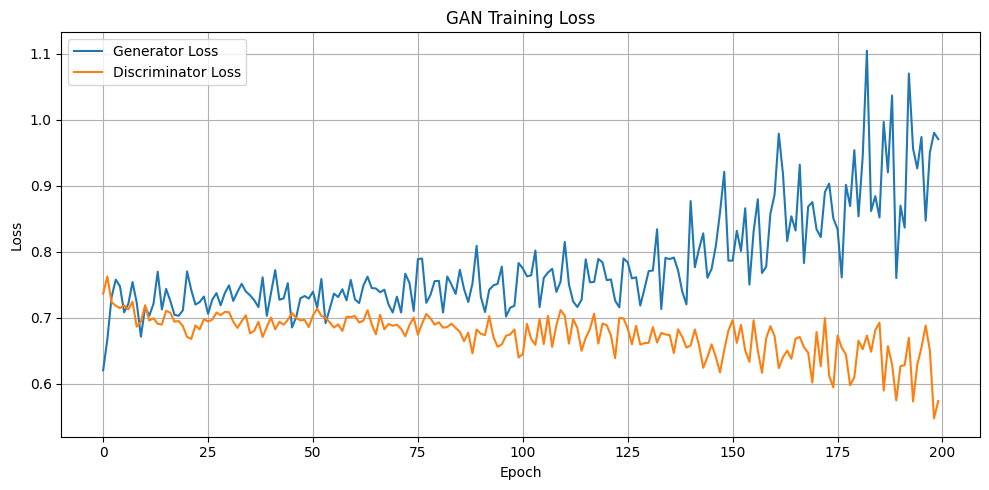

In [29]:
epochs = range(len(gen_loss_history))

plt.figure(figsize=(10, 5))
plt.plot(epochs, gen_loss_history, label='Generator Loss')
plt.plot(epochs, dis_loss_history, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{result_dir}/loss_plot.png")
plt.show()


In [30]:
# Save model 
os.makedirs(model_dir, exist_ok=True) 
torch.save(generator.state_dict(), f"{model_dir}/gen.model") 
torch.save(discriminator.state_dict(), f"{model_dir}/dis.model") 


In [31]:
# Load model 
model = Generator(img_size=img_size, latent_dim=latent_dim, channels=3).to(device) 
model.load_state_dict(torch.load(f"{model_dir}/gen.model", weights_only=True))
model.eval() 

Generator(
  (in_layer): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
  )
  (model): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Tanh()
  )
)

In [32]:
# Walking the latent space 
z1 = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim)))) 
z2 = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim)))) 

generated1 = model(z1) 
generated2 = model(z2) 

save_image(generated1.data, f"{result_dir}/TEST_START.png")   
save_image(generated2.data, f"{result_dir}/TEST_END.png")   

from scipy.interpolate import interp1d
num_samples = 10 

# Generate random start and endpoints 
z1 = np.array(z1.cpu()) 
z2 = np.array(z2.cpu()) 
linfit = interp1d([0,num_samples-1], np.vstack([z1, z2]), axis=0) 

inputs = [] 
for i in range(num_samples): 
    inputs.append(linfit(i)) 
inputs = Tensor(inputs) 
images = model(inputs) 

save_image(images, f"{result_dir}/Latent_walk.png" , nrow=num_samples) 

In [33]:
# 14
# 15, 194

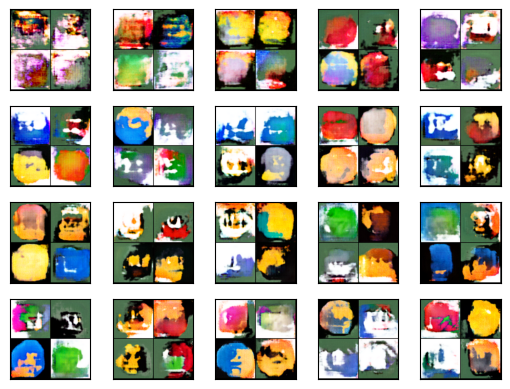

In [ ]:
# Images per epoch experiment 
all_files = glob.glob("images/epoch_*.png")
all_files.sort(key= lambda input : int(input.split('_')[1].split('.')[0])) 

fig, ax = plt.subplots(4,5) 
row, col,i = 0, 0, 0 
for image_dir in all_files: 
    img = Image.open(image_dir) 
    ax[row,col].imshow(img) 
    ax[row,col].set_yticks([]) 
    ax[row,col].set_xticks([]) 
    i += 1 
    col = i % 5 
    row = i // 5 
plt.show() 

